<a href="https://colab.research.google.com/github/vaibhavsundharam/Speech-Emotion-Analysis/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#General Initialization (Run)

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# modify "customized_path_to_project", path of folder in drive, where you have stored your project
customized_path_to_project = "/content/drive/MyDrive/Deep Learning/DL Project"
sys.path.append(customized_path_to_project)

# Data Exploration (Run)

Importing the dataset<br>

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
2. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
3. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
4. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
5. Repetition (01 = 1st repetition, 02 = 2nd repetition).
6. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
RAVDESS = os.path.join(customized_path_to_project, "Data", "RAVDESS")

# Looking at folders in this directory (should be 24) 
list_dir = os.listdir(RAVDESS)
list_dir.sort()
print(f"DIR Name: {list_dir}\n") # Actor 1 - Actor 24

emotion = []
gender = []
path = []
c = 1

for i in list_dir:
  filename = os.listdir(RAVDESS +'/' + i) #files in 'Actor 1' type folders (03-01-01-01-01-01-01.wav) 
  print(f"Counter :{c}\nFilename :{filename}\nNumber of .wav files: {len(filename)}\n\n")
  c += 1 
  for f in filename:    
    part = f.split('.')[0].split('-')  #getting labels i.e. 03 01 02 ... from "03-01-01-01-01-01-01.wav"      
    emotion.append(int(part[2]))
    temp = int(part[6])
    if temp % 2 == 0:
      temp = "female"
    else:
      temp = "male"
    gender.append(temp)
    path.append(RAVDESS + '/' + i + '/' + f)

DIR Name: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']

Counter :1
Filename :['03-01-01-01-01-01-01.wav', '03-01-01-01-01-02-01.wav', '03-01-01-01-02-01-01.wav', '03-01-01-01-02-02-01.wav', '03-01-02-01-01-01-01.wav', '03-01-02-01-02-01-01.wav', '03-01-02-01-01-02-01.wav', '03-01-02-01-02-02-01.wav', '03-01-02-02-01-01-01.wav', '03-01-02-02-01-02-01.wav', '03-01-02-02-02-01-01.wav', '03-01-02-02-02-02-01.wav', '03-01-03-01-01-01-01.wav', '03-01-03-01-01-02-01.wav', '03-01-03-01-02-01-01.wav', '03-01-03-01-02-02-01.wav', '03-01-03-02-01-01-01.wav', '03-01-03-02-01-02-01.wav', '03-01-03-02-02-01-01.wav', '03-01-03-02-02-02-01.wav', '03-01-04-01-01-01-01.wav', '03-01-04-01-01-02-01.wav', '03-01-04-01-02-01-01.wav', '03-01-04-01-02-02-01.wav', '03-01

##Putting necessary information into Data Frames and saving to csv files

In [ ]:
data_frame = RAVDESS_df = pd.DataFrame(path)
data_frame = pd.concat([pd.DataFrame(gender), RAVDESS_df], axis=1)
data_frame.columns = ['gender','path']
print(data_frame)

      gender                                               path
0       male  /content/drive/MyDrive/Deep Learning/DL Projec...
1       male  /content/drive/MyDrive/Deep Learning/DL Projec...
2       male  /content/drive/MyDrive/Deep Learning/DL Projec...
3       male  /content/drive/MyDrive/Deep Learning/DL Projec...
4       male  /content/drive/MyDrive/Deep Learning/DL Projec...
...      ...                                                ...
1435  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1436  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1437  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1438  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1439  female  /content/drive/MyDrive/Deep Learning/DL Projec...

[1440 rows x 2 columns]


##Seperating out *male* and *female* voices

In [ ]:
data_frame_male = data_frame.loc[data_frame['gender'] == 'male']
print(data_frame_male)
data_frame_male.to_csv('male.csv', index=False) 

     gender                                               path
0      male  /content/drive/MyDrive/Deep Learning/DL Projec...
1      male  /content/drive/MyDrive/Deep Learning/DL Projec...
2      male  /content/drive/MyDrive/Deep Learning/DL Projec...
3      male  /content/drive/MyDrive/Deep Learning/DL Projec...
4      male  /content/drive/MyDrive/Deep Learning/DL Projec...
...     ...                                                ...
1375   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1376   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1377   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1378   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1379   male  /content/drive/MyDrive/Deep Learning/DL Projec...

[720 rows x 2 columns]


In [ ]:
data_frame_female = data_frame.loc[data_frame['gender'] == 'female']
data_frame_female.to_csv('female.csv', index=False) 
print(data_frame_female)

      gender                                               path
60    female  /content/drive/MyDrive/Deep Learning/DL Projec...
61    female  /content/drive/MyDrive/Deep Learning/DL Projec...
62    female  /content/drive/MyDrive/Deep Learning/DL Projec...
63    female  /content/drive/MyDrive/Deep Learning/DL Projec...
64    female  /content/drive/MyDrive/Deep Learning/DL Projec...
...      ...                                                ...
1435  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1436  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1437  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1438  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1439  female  /content/drive/MyDrive/Deep Learning/DL Projec...

[720 rows x 2 columns]


Playing audio file and plotting it to look at the output

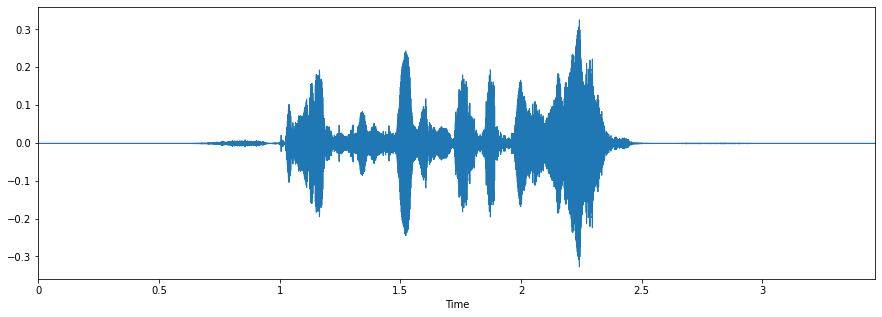

In [ ]:
# Picking a fearful track
fname = RAVDESS + '/' + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Playing the audio 
ipd.Audio(fname)

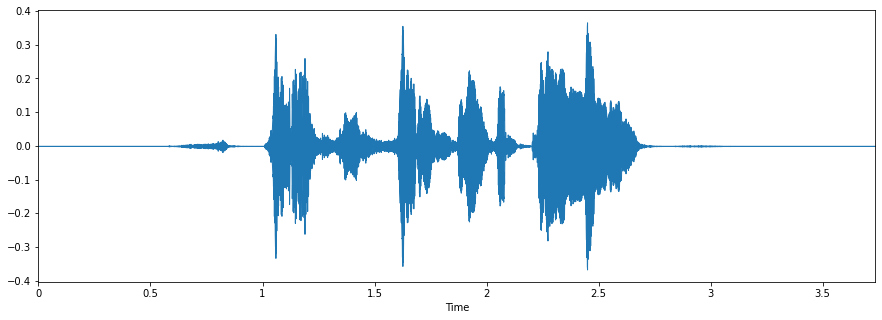

In [ ]:
# Picking a happy track
fname = RAVDESS + '/' + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Playing the audio 
ipd.Audio(fname)

# Feature Extraction (Run)

Using MFCC - Mel -frequency Cepstarl Coefficient

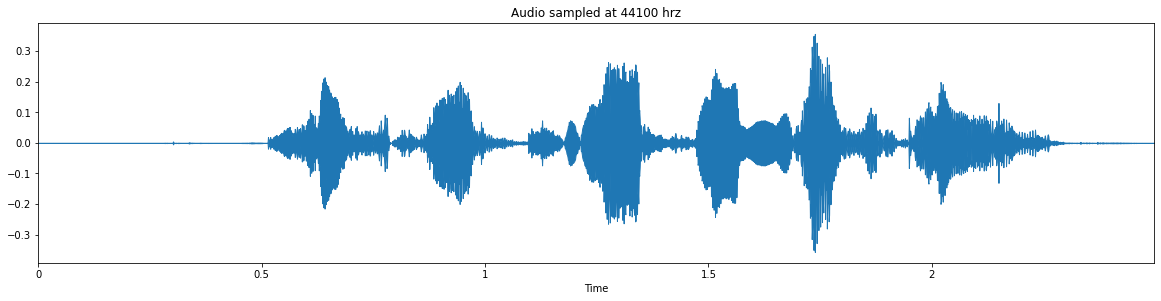

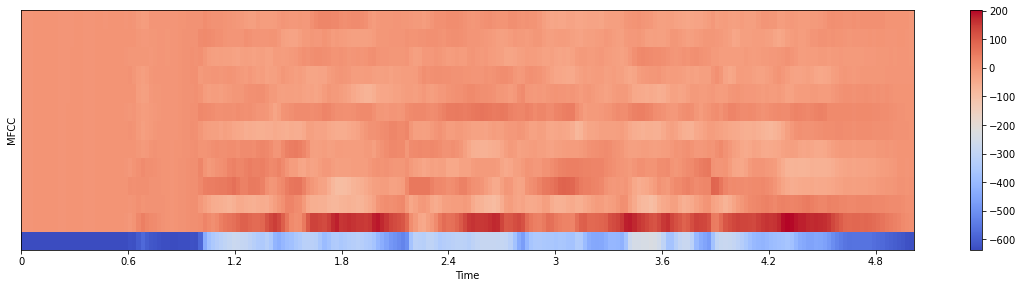

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
pathf = os.path.join(customized_path_to_project,"Data/RAVDESS/Actor_08/03-01-05-02-01-01-08.wav")
Xf, sample_ratef = librosa.load(pathf, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(pathf)

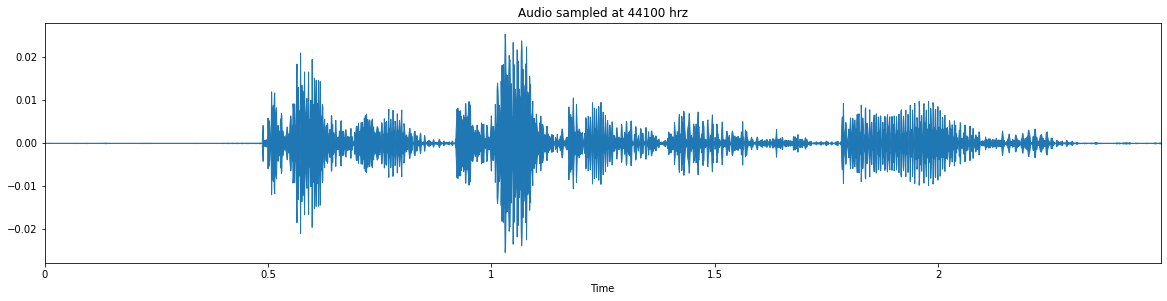

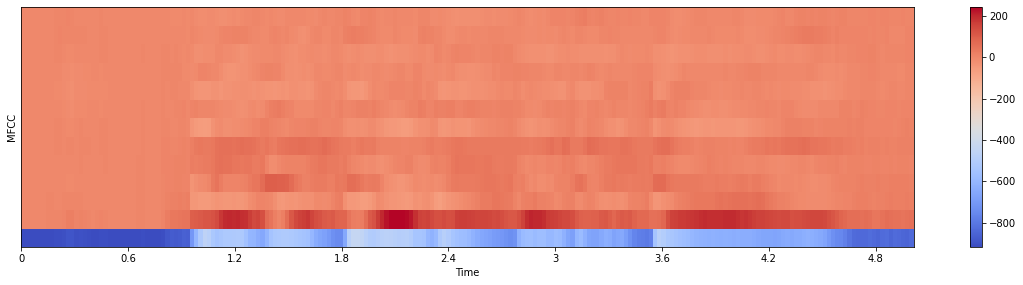

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
pathm = os.path.join(customized_path_to_project,"Data/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav")
Xm, sample_ratem = librosa.load(pathm, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xm, sr=sample_ratem)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(pathm)

216
216


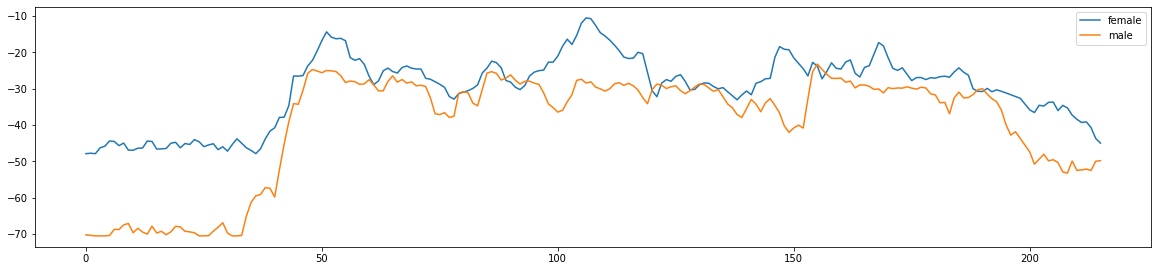

In [ ]:
#coeffiecients for female voice
female = np.mean(librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13), axis=0)
print(len(female))

#coefficients for male voice
male = np.mean(librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [ ]:
n 

# Data Pre-processing (Run once)

processing male voices

In [ ]:
csv_m = pd.read_csv("/content/male.csv")
Data_Frame_m = pd.DataFrame(columns=["feature"])
counter = 0

for i, p in tqdm(enumerate(csv_m.path)):
  Xm, sample_ratem = librosa.load(p, sr = 44100, offset=0.5, duration=2.5 , res_type='kaiser_fast')
  sample_ratem = np.array(sample_ratem)
  mfcc_m = np.mean(librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13),axis=0)
  Data_Frame_m.loc[i] = [mfcc_m]

720it [01:57,  6.13it/s]


In [ ]:
Data_Frame_m = Data_Frame_m.fillna(0)
Data_Frame_m = pd.DataFrame(Data_Frame_m['feature'].values.tolist())
Data_Frame_m.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,-55.660589,-53.222069,...,-59.615328,-56.169903,-57.875562,-61.149496,-62.058126,-58.724914,-56.277627,-58.083108,-60.733636,-62.754215,-63.549244,-64.526266,-65.800971,-65.771172,-62.390423,-60.171205,-61.831569,-64.845866,-64.133097,-63.383669,-61.310815,-60.995465,-62.350353,-62.845241,-60.302466,-58.946521,-59.711816,-56.837098,-56.425769,-56.877954,-58.299903,-62.295248,-64.930130,-65.332128,-64.116934,-64.319911,-64.971422,-63.155779,-64.178668,-63.061902
1,-61.849949,-62.895033,-63.830647,-60.552590,-60.821684,-62.073396,-64.889228,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-63.679656,-59.562475,-59.068306,-62.143033,-62.431462,-64.841821,-65.389948,-65.389948,-63.869841,-61.360492,-59.707017,-59.798056,-62.271154,-60.549896,-58.221012,-58.358541,-60.648374,-53.253787,-51.222221,-49.679046,-51.875681,-56.024106,-57.659168,-58.432061,-58.607403,-60.929774,-64.418912,-58.209214,...,-53.208478,-54.152441,-52.782883,-53.128404,-57.195379,-55.770453,-55.109805,-57.923445,-56.826748,-57.972347,-56.143225,-53.263351,-55.030139,-58.031881,-62.373600,-63.339109,-59.324894,-58.807633,-62.784229,-63.298385,-63.522439,-64.283955,-64.732161,-61.390440,-60.565392,-61.248813,-64.317986,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948
2,-65.818869,-65.818869,-65.818869,-65.818869,-65.805538,-65.818869,-65.818869,-65.629539,-64.802625,-65.818869,-65.818869,-65.818869,-65.818869,-65.108404,-65.818869,-65.818869,-65.818869,-65.261425,-65.123928,-65.818869,-64.191042,-61.744355,-61.067486,-61.839816,-65.328680,-65.211158,-65.663178,-65.818869,-65.818869,-65.816125,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.470501,-62.254325,-59.888393,-62.292810,-60.520293,...,-58.574695,-59.631354,-60.101534,-58.546990,-59.596250,-61.501059,-59.898731,-61.415549,-63.316846,-62.846409,-61.955321,-65.802359,-62.626907,-59.936369,-61.786325,-65.818869,-65.189666,-65.818869,-65.818869,-65.818869,-65.522793,-65.663626,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.438060,-65.684853,-65.818869,-65.818869,-65.818869,-65.818869
3,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-65.682145,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-65.750829,-63.380211,-62.699950,-65.097628,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.002158,-61.924173,-59.584440,-56.339228,-54.955639,-55.590584,...,-55.763687,-58.544620,-55.987887,-56.974609,-61.779677,-65.383069,-63.934941,-63.327847,-62.010690,-61.250412,-62.366334,-62.562523,-61.351269,-63.538979,-64.852010,-61.058000,-60.733821,-62.970143,-65.924813,-66.058485,-66.058485,-65.232852,-64.616167,-65.550135,-66.058485,-66.058485,-65.295684,-61.710804,-60.359995,-60.372977,-57.539617,-55.826307,-57.741989,-59.796385,-60.975377,-62.663056,-64.573480,-63.782612,-61.515785,-58.214885
4,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.000654,-69.980825,-70.267764,-70.267764,-70

In [ ]:
# Normalization across dataset 
mean = np.mean(Data_Frame_m, axis=0)
std = np.std(Data_Frame_m, axis=0)
Data_Frame_m = (Data_Frame_m - mean)/std
Data_Frame_m = Data_Frame_m.fillna(0)
print("Normalized Dataframe\n")
Data_Frame_m.head()

Normalized Dataframe



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-1.234003,-1.295916,-1.315044,-1.301825,-1.292483,-1.302988,-1.283187,-1.262130,-1.272880,-1.278912,-1.291820,-1.281339,-1.262614,-1.277889,-1.278607,-1.272105,-1.283941,-1.291092,-1.296267,-1.298674,-1.096793,-0.638336,-0.803781,-0.593218,-0.797223,-0.707163,-0.617609,-0.573963,-0.277142,-0.364977,-0.077248,-0.045117,-0.330143,-0.288688,-0.246588,-0.383944,-0.501093,-0.614985,-0.631797,-0.475430,...,-1.982100,-1.662459,-1.763764,-1.990740,-2.024696,-1.705865,-1.482608,-1.593745,-1.766411,-1.899692,-1.947037,-1.993798,-2.050183,-2.022176,-1.718649,-1.539016,-1.661619,-1.840033,-1.764122,-1.694447,-1.518525,-1.480654,-1.568082,-1.603499,-1.381269,-1.241083,-1.277665,-1.033983,-0.977076,-0.997312,-1.095739,-1.395768,-1.593179,-1.607021,-1.503859,-1.506732,-1.528722,-1.370389,-1.389389,-1.208477
1,-0.761100,-0.940132,-1.068377,-0.645323,-0.673448,-0.841452,-1.172377,-1.212544,-1.223128,-1.229414,-1.242163,-1.231852,-1.010262,-0.537458,-0.485582,-0.844397,-0.891202,-1.179443,-1.248662,-1.251137,-1.093720,-0.788567,-0.606564,-0.627265,-0.909003,-0.715267,-0.457347,-0.466183,-0.704510,0.104926,0.320100,0.469050,0.191808,-0.288946,-0.513763,-0.656315,-0.766812,-1.099133,-1.599752,-1.055706,...,-1.455392,-1.497309,-1.349367,-1.343072,-1.635104,-1.471400,-1.390054,-1.581134,-1.459054,-1.524010,-1.361970,-1.108068,-1.210815,-1.421396,-1.717351,-1.785169,-1.466700,-1.378580,-1.661009,-1.687874,-1.689377,-1.735786,-1.752883,-1.489866,-1.401892,-1.421029,-1.637264,-1.704561,-1.677439,-1.663165,-1.654227,-1.639637,-1.629441,-1.611596,-1.605482,-1.592228,-1.562088,-1.549714,-1.480849,-1.370297
2,-1.236145,-1.298107,-1.317284,-1.304064,-1.293051,-1.305204,-1.285362,-1.241448,-1.152035,-1.281068,-1.293982,-1.283494,-1.264743,-1.195690,-1.280716,-1.274198,-1.286943,-1.228286,-1.217851,-1.300744,-1.131241,-0.833025,-0.765851,-0.865757,-1.262508,-1.251373,-1.308667,-1.308649,-1.279856,-1.295998,-1.309988,-1.312114,-1.325695,-1.333313,-1.385849,-1.406563,-1.157605,-0.986941,-1.364779,-1.324611,...,-1.896550,-1.945813,-1.944893,-1.780599,-1.827456,-1.926180,-1.769595,-1.856955,-1.969633,-1.906935,-1.821119,-2.094152,-1.802829,-1.569236,-1.672058,-1.977851,-1.922745,-1.914392,-1.892990,-1.882144,-1.843908,-1.842825,-1.837199,-1.835768,-1.813961,-1.778223,-1.754437,-1.738190,-1.710950,-1.696718,-1.688014,-1.673437,-1.663266,-1.645541,-1.609322,-1.615791,-1.596283,-1.584141,-1.513235,-1.400111
3,-1.264825,-1.327444,-1.347282,-1.334036,-1.324498,-1.334872,-1.314484,-1.293196,-1.304051,-1.309924,-1.322931,-1.312344,-1.293248,-1.308452,-1.264611,-1.302215,-1.314937,-1.321067,-1.326092,-1.328457,-1.349387,-1.297042,-1.036630,-0.966227,-1.235794,-1.348827,-1.353887,-1.335708,-1.306519,-1.323026,-1.336748,-1.338558,-1.351773,-1.358862,-1.405438,-1.028550,-0.871509,-0.604576,-0.553887,-0.751017,...,-1.665456,-1.856853,-1.610162,-1.653636,-2.002387,-2.234255,-2.089480,-2.007997,-1.866878,-1.781547,-1.853589,-1.839367,-1.703419,-1.848897,-1.908497,-1.607922,-1.576258,-1.696687,-1.901089,-1.900612,-1.885291,-1.809404,-1.743883,-1.814777,-1.832756,-1.796951,-1.713592,-1.416101,-1.284454,-1.270711,-1.035851,-0.886002,-1.026320,-1.168928,-1.253073,-1.374348,-1.496996,-1.420702,-1.188324,-0.871566
4,-1.768638,-1.842800,-1.874247,-1.860561,-1.847804,-1.856050,-1.826063,-1.801005,-1.813567,-1.816835,-1.831462,-1.819147,-1.762209,-1.773984,-1.804741,-1.794389,-1.806696,-1.811044,-1.813612,-1.815288,-1.353815,-1.024463,-1.607954,-1.850202,-1.763894,-1.666107,-1.360313,-1.092074,-1.591620,-1.792435,-1.736937,-1.599188,-1.785555,-1.484038,-1.442657,-1.729855,-1.620873,-1.320115,-1.409060,-1.951340,...,-0.370314,-0.304637,-0.397226,-0.430931,-0.524105,-0.601613,-0.716101,-0.598003,-0.822022,-1.037412

In [ ]:
Data_Frame_m = pd.concat([csv_m, Data_Frame_m], axis=1)
print("Final Dataframe\n")
Data_Frame_m.head()

Final Dataframe



,gender,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,male,/content/drive/MyDrive/Deep Learning/DL Projec...,-1.234003,-1.295916,-1.315044,-1.301825,-1.292483,-1.302988,-1.283187,-1.262130,-1.272880,-1.278912,-1.291820,-1.281339,-1.262614,-1.277889,-1.278607,-1.272105,-1.283941,-1.291092,-1.296267,-1.298674,-1.096793,-0.638336,-0.803781,-0.593218,-0.797223,-0.707163,-0.617609,-0.573963,-0.277142,-0.364977,-0.077248,-0.045117,-0.330143,-0.288688,-0.246588,-0.383944,-0.501093,-0.614985,...,-1.982100,-1.662459,-1.763764,-1.990740,-2.024696,-1.705865,-1.482608,-1.593745,-1.766411,-1.899692,-1.947037,-1.993798,-2.050183,-2.022176,-1.718649,-1.539016,-1.661619,-1.840033,-1.764122,-1.694447,-1.518525,-1.480654,-1.568082,-1.603499,-1.381269,-1.241083,-1.277665,-1.033983,-0.977076,-0.997312,-1.095739,-1.395768,-1.593179,-1.607021,-1.503859,-1.506732,-1.528722,-1.370389,-1.389389,-1.208477
1,male,/content/drive/MyDrive/Deep Learning/DL Projec...,-0.761100,-0.940132,-1.068377,-0.645323,-0.673448,-0.841452,-1.172377,-1.212544,-1.223128,-1.229414,-1.242163,-1.231852,-1.010262,-0.537458,-0.485582,-0.844397,-0.891202,-1.179443,-1.248662,-1.251137,-1.093720,-0.788567,-0.606564,-0.627265,-0.909003,-0.715267,-0.457347,-0.466183,-0.704510,0.104926,0.320100,0.469050,0.191808,-0.288946,-0.513763,-0.656315,-0.766812,-1.099133,...,-1.455392,-1.497309,-1.349367,-1.343072,-1.635104,-1.471400,-1.390054,-1.581134,-1.459054,-1.524010,-1.361970,-1.108068,-1.210815,-1.421396,-1.717351,-1.785169,-1.466700,-1.378580,-1.661009,-1.687874,-1.689377,-1.735786,-1.752883,-1.489866,-1.401892,-1.421029,-1.637264,-1.704561,-1.677439,-1.663165,-1.654227,-1.639637,-1.629441,-1.611596,-1.605482,-1.592228,-1.562088,-1.549714,-1.480849,-1.370297
2,male,/content/drive/MyDrive/Deep Learning/DL Projec...,-1.236145,-1.298107,-1.317284,-1.304064,-1.293051,-1.305204,-1.285362,-1.241448,-1.152035,-1.281068,-1.293982,-1.283494,-1.264743,-1.195690,-1.280716,-1.274198,-1.286943,-1.228286,-1.217851,-1.300744,-1.131241,-0.833025,-0.765851,-0.865757,-1.262508,-1.251373,-1.308667,-1.308649,-1.279856,-1.295998,-1.309988,-1.312114,-1.325695,-1.333313,-1.385849,-1.406563,-1.157605,-0.986941,...,-1.896550,-1.945813,-1.944893,-1.780599,-1.827456,-1.926180,-1.769595,-1.856955,-1.969633,-1.906935,-1.821119,-2.094152,-1.802829,-1.569236,-1.672058,-1.977851,-1.922745,-1.914392,-1.892990,-1.882144,-1.843908,-1.842825,-1.837199,-1.835768,-1.813961,-1.778223,-1.754437,-1.738190,-1.710950,-1.696718,-1.688014,-1.673437,-1.663266,-1.645541,-1.609322,-1.615791,-1.596283,-1.584141,-1.513235,-1.400111
3,male,/content/drive/MyDrive/Deep Learning/DL Projec...,-1.264825,-1.327444,-1.347282,-1.334036,-1.324498,-1.334872,-1.314484,-1.293196,-1.304051,-1.309924,-1.322931,-1.312344,-1.293248,-1.308452,-1.264611,-1.302215,-1.314937,-1.321067,-1.326092,-1.328457,-1.349387,-1.297042,-1.036630,-0.966227,-1.235794,-1.348827,-1.353887,-1.335708,-1.306519,-1.323026,-1.336748,-1.338558,-1.351773,-1.358862,-1.405438,-1.028550,-0.871509,-0.604576,...,-1.665456,-1.856853,-1.610162,-1.653636,-2.002387,-2.234255,-2.089480,-2.007997,-1.866878,-1.781547,-1.853589,-1.839367,-1.703419,-1.848897,-1.908497,-1.607922,-1.576258,-1.696687,-1.901089,-1.900612,-1.885291,-1.809404,-1.743883,-1.814777,-1.832756,-1.796951,-1.713592,-1.416101,-1.284454,-1.270711,-1.035851,-0.886002,-1.026320,-1.168928,-1.253073,-1.374348,-1.496996,-1.420702,-1.188324,-0.871566
4,male,/content/drive/MyDrive/Deep Learning/DL Projec...,-1.768638,-1.842800,-1.874247,-1.860561,-1.847804,-1.856050,-1.826063,-1.801005,-1.813567,-1.816835,-1.831462,-1.819147,-1.762209,-1.773984,-1.804741,-1.794389,-1.806696,-1.811044,-1.813612,-1.815288,-1.353815,-1.024463,-1.607954,-1.850202,-1.763894,-1.666107,-1.360313,-1.092074,-1.591620,-1.792435,-1

In [ ]:
# saving DF to a csv file
Data_Frame_m.to_csv('male_with_features.csv', index=False) 

Processing female voices

In [ ]:
csv_f = pd.read_csv("/content/female.csv")
Data_Frame_f = pd.DataFrame(columns=['feature'])

counter = 0
for i, p in tqdm(enumerate(csv_f.path)):
  Xf, sample_ratef = librosa.load(p, sr = 44100, offset=0.5, duration=2.5 , res_type='kaiser_fast')
  sample_ratef = np.array(sample_ratef)
  mfcc_f = np.mean(librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13),axis=0)
  Data_Frame_f.loc[counter] = [mfcc_f]
  counter = counter + 1

720it [08:23,  1.43it/s]


In [ ]:
Data_Frame_f = Data_Frame_f.fillna(0)
Data_Frame_f = pd.DataFrame(Data_Frame_f['feature'].values.tolist())
Data_Frame_f.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.167273,-63.385486,-63.461856,-63.336160,-63.204256,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.304840,-63.224103,-63.214204,-63.214204,-63.214204,-63.240308,-63.331829,-63.373934,-63.219163,-63.228675,-63.267012,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.214204,-63.092103,...,-33.563106,-36.922018,-34.637622,-34.049463,-32.516619,-32.252630,-35.323312,-36.909857,-38.544525,-41.462137,-41.712770,-42.326984,-43.196594,-44.127289,-44.722428,-47.005262,-52.414442,-56.311606,-56.920008,-52.116141,-47.951037,-48.240699,-49.206920,-52.699369,-54.648328,-51.877090,-51.305507,-53.409502,-54.568682,-51.800832,-50.994126,-53.428584,-53.139486,-52.853875,-55.247733,-57.681998,-57.166072,-57.039674,-56.066060,-58.502809
1,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-62.811329,-62.514053,-61.964468,-60.250857,-59.083518,-58.098570,-59.997710,-61.747985,-62.070999,-62.552692,-62.837412,-62.749919,-63.052156,-63.052156,-63.052156,-62.873932,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,-63.052156,...,-30.931500,-29.831228,-31.253324,-32.517173,-35.776260,-35.927450,-35.125432,-36.354759,-39.342202,-41.965193,-40.904075,-39.982636,-42.109332,-43.347460,-44.794943,-48.269767,-51.068901,-49.918334,-51.636293,-54.085863,-53.644552,-56.600657,-58.051156,-54.172947,-54.647637,-52.998381,-54.528118,-54.250085,-53.362839,-54.624081,-54.385401,-54.003382,-55.091402,-55.259032,-54.581650,-54.561684,-59.238109,-60.861345,-54.298284,-53.452315
2,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.332473,-60.354142,-60.012698,-58.992602,-59.636484,-59.711650,-59.902486,-60.354142,-60.465017,-59.825603,-59.774483,-60.456522,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-60.354142,-59.965860,-58.374830,-59.207235,-60.354142,-60.354142,-60.354142,-54.466607,...,-30.139433,-29.212283,-30.147683,-30.609083,-30.587582,-29.983835,-30.852893,-31.221688,-29.952620,-29.090116,-30.665424,-30.694813,-31.162334,-32.250774,-32.997705,-34.344499,-36.220694,-37.011351,-37.836375,-38.719347,-40.781584,-44.249722,-45.027947,-42.457136,-42.037206,-44.613230,-46.154605,-46.482167,-46.859874,-50.653921,-52.027792,-50.803584,-49.274334,-48.952462,-52.151521,-54.814622,-58.939016,-57.146994,-49.602971,-48.615914
3,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.961411,-62.456734,-62.415457,-61.041872,-62.479233,-61.767978,-61.033400,-61.960348,-60.733661,-60.574343,-61.790668,-62.908566,-62.955490,-62.986108,-62.768028,-62.849289,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.986108,-62.841990,-62.986108,-62.986108,-62.891389,-62.603111,-62.658430,-62.888169,-62.809019,-62.629097,...,-34.452049,-37.824396,-38.278346,-37.470792,-39.076624,-38.668468,-41.405209,-44.597685,-43.188804,-42.917491,-47.098692,-47.530115,-48.623046,-48.332117,-50.566211,-52.705997,-56.621471,-54.948690,-55.341077,-51.119734,-52.685327,-56.207851,-53.382435,-52.864642,-54.388536,-52.983870,-52.599625,-53.266324,-55.801462,-55.197528,-54.814880,-53.828486,-52.249828,-55.147179,-56.926146,-56.589483,-58.407538,-59.524161,-58.547470,-56.937227
4,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,-54.665957,-56.481771,-60.643311,-60.328460,-57.369862,-57.232729,-57

In [ ]:
# Normalization
mean = np.mean(Data_Frame_f, axis=0)
std = np.std(Data_Frame_f, axis=0)
Data_Frame_f = (Data_Frame_f - mean)/std
Data_Frame_f = Data_Frame_f.fillna(0)
print("Normalized Dataframe\n")
Data_Frame_f.head()

Normalized Dataframe



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-0.796852,-0.816062,-0.820825,-0.832818,-0.832840,-0.822510,-0.849859,-0.869938,-0.868440,-0.854857,-0.856736,-0.865434,-0.874135,-0.874499,-0.875021,-0.880394,-0.904244,-0.892313,-0.887640,-0.891584,-0.891499,-0.899394,-0.908974,-0.908120,-0.887746,-0.889587,-0.887318,-0.881147,-0.882673,-0.877904,-0.875192,-0.868918,-0.874693,-0.875081,-0.881606,-0.907745,-0.929547,-0.961026,-1.021544,-1.103871,...,0.587424,0.184585,0.486292,0.581619,0.791926,0.819612,0.482126,0.342168,0.203322,-0.074147,-0.069302,-0.101439,-0.155835,-0.205031,-0.230044,-0.424761,-0.923883,-1.271014,-1.283632,-0.775196,-0.340218,-0.323713,-0.373892,-0.676864,-0.842668,-0.545881,-0.456972,-0.617373,-0.702194,-0.417048,-0.306780,-0.509543,-0.452668,-0.401813,-0.616607,-0.837820,-0.762008,-0.719259,-0.599945,-0.749189
1,-0.778079,-0.797319,-0.802129,-0.814104,-0.814212,-0.809353,-0.811998,-0.823392,-0.836067,-0.837493,-0.838344,-0.847036,-0.855648,-0.856060,-0.856708,-0.862112,-0.875820,-0.873093,-0.842893,-0.814613,-0.754909,-0.573305,-0.448824,-0.343025,-0.545897,-0.733347,-0.761086,-0.811109,-0.842821,-0.828678,-0.858021,-0.851888,-0.857670,-0.839598,-0.864688,-0.890569,-0.912137,-0.943515,-1.003712,-1.099358,...,0.920999,1.059832,0.897260,0.765044,0.405839,0.398753,0.504118,0.403786,0.115115,-0.129242,0.017815,0.145957,-0.043009,-0.125861,-0.237250,-0.549481,-0.791993,-0.646687,-0.770023,-0.965130,-0.879525,-1.103964,-1.204126,-0.818483,-0.842601,-0.654879,-0.768468,-0.698243,-0.585054,-0.695533,-0.640338,-0.565616,-0.641936,-0.635638,-0.551652,-0.530360,-0.966590,-1.096762,-0.452842,-0.382195
2,-0.465520,-0.485272,-0.490853,-0.502522,-0.504059,-0.498530,-0.505550,-0.478077,-0.373332,-0.447561,-0.459217,-0.489444,-0.547855,-0.561675,-0.492079,-0.492336,-0.583843,-0.571508,-0.569975,-0.577166,-0.578909,-0.584572,-0.586450,-0.584641,-0.583720,-0.586272,-0.579882,-0.578336,-0.580170,-0.574666,-0.572139,-0.568357,-0.574235,-0.536350,-0.376379,-0.483019,-0.622278,-0.651963,-0.706829,-0.129558,...,1.021399,1.136231,1.031522,0.993454,1.020411,1.079446,0.978957,0.973573,1.153408,1.280825,1.120781,1.126087,1.092974,1.000701,0.935043,0.823990,0.663437,0.613729,0.571413,0.516614,0.338894,0.048772,0.018400,0.307467,0.384153,0.160219,0.040912,0.049094,0.046666,-0.303916,-0.408449,-0.253467,-0.077883,-0.022526,-0.314669,-0.555284,-0.937059,-0.729860,-0.062127,-0.030758
3,-0.770428,-0.789681,-0.794509,-0.806476,-0.806619,-0.801805,-0.804496,-0.815888,-0.828538,-0.827134,-0.770768,-0.774749,-0.626312,-0.790868,-0.711584,-0.634363,-0.753005,-0.613931,-0.594433,-0.735089,-0.858094,-0.868326,-0.871527,-0.843215,-0.848497,-0.863992,-0.857670,-0.856997,-0.858548,-0.853720,-0.851023,-0.829802,-0.850731,-0.851296,-0.847904,-0.842971,-0.869838,-0.925794,-0.976958,-1.051571,...,0.474744,0.073200,0.044186,0.172065,0.014929,0.084837,-0.193801,-0.511205,-0.310239,-0.233536,-0.649504,-0.650518,-0.718945,-0.631915,-0.810742,-0.987033,-1.336259,-1.137920,-1.130150,-0.679115,-0.788664,-1.067303,-0.765860,-0.692748,-0.817395,-0.653468,-0.582060,-0.603598,-0.821950,-0.752098,-0.682580,-0.548555,-0.366402,-0.624764,-0.780284,-0.730169,-0.884584,-0.964676,-0.806433,-0.635426
4,-1.085713,-1.104450,-0.809348,-0.637046,-0.589470,-0.851919,-0.887861,-0.119284,0.062512,0.122836,0.113440,-0.101079,-0.580844,-0.546136,-0.214558,-0.205584,-0.202695,-0.406722,-0.627189,-0.583223,-0.154978,-0.182176,-0.861254,-0.861396,-0.834964,-0.939414,-1.059741,-1.133877,-1.146401,-1.012567,-0.380051,-0.190412,-0.415714,-0.490592,-0.853774,-0.853980,-0.828224,-0.912154,-1.137456,-1.203790,...,0.331819,0.377442,0.411449,0.209296,0.183672,0.441240,0.531545,0.449274,0.405120,0.435139,0.897483,1.018147,1.166292,1.184475,1.140334,1.143418,1.122423,

In [ ]:
Data_Frame_f = pd.concat([csv_f, Data_Frame_f], axis=1)
print("Final Dataframe\n")
Data_Frame_f.head()

Final Dataframe



,gender,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,female,/content/drive/MyDrive/Deep Learning/DL Projec...,-0.796852,-0.816062,-0.820825,-0.832818,-0.832840,-0.822510,-0.849859,-0.869938,-0.868440,-0.854857,-0.856736,-0.865434,-0.874135,-0.874499,-0.875021,-0.880394,-0.904244,-0.892313,-0.887640,-0.891584,-0.891499,-0.899394,-0.908974,-0.908120,-0.887746,-0.889587,-0.887318,-0.881147,-0.882673,-0.877904,-0.875192,-0.868918,-0.874693,-0.875081,-0.881606,-0.907745,-0.929547,-0.961026,...,0.587424,0.184585,0.486292,0.581619,0.791926,0.819612,0.482126,0.342168,0.203322,-0.074147,-0.069302,-0.101439,-0.155835,-0.205031,-0.230044,-0.424761,-0.923883,-1.271014,-1.283632,-0.775196,-0.340218,-0.323713,-0.373892,-0.676864,-0.842668,-0.545881,-0.456972,-0.617373,-0.702194,-0.417048,-0.306780,-0.509543,-0.452668,-0.401813,-0.616607,-0.837820,-0.762008,-0.719259,-0.599945,-0.749189
1,female,/content/drive/MyDrive/Deep Learning/DL Projec...,-0.778079,-0.797319,-0.802129,-0.814104,-0.814212,-0.809353,-0.811998,-0.823392,-0.836067,-0.837493,-0.838344,-0.847036,-0.855648,-0.856060,-0.856708,-0.862112,-0.875820,-0.873093,-0.842893,-0.814613,-0.754909,-0.573305,-0.448824,-0.343025,-0.545897,-0.733347,-0.761086,-0.811109,-0.842821,-0.828678,-0.858021,-0.851888,-0.857670,-0.839598,-0.864688,-0.890569,-0.912137,-0.943515,...,0.920999,1.059832,0.897260,0.765044,0.405839,0.398753,0.504118,0.403786,0.115115,-0.129242,0.017815,0.145957,-0.043009,-0.125861,-0.237250,-0.549481,-0.791993,-0.646687,-0.770023,-0.965130,-0.879525,-1.103964,-1.204126,-0.818483,-0.842601,-0.654879,-0.768468,-0.698243,-0.585054,-0.695533,-0.640338,-0.565616,-0.641936,-0.635638,-0.551652,-0.530360,-0.966590,-1.096762,-0.452842,-0.382195
2,female,/content/drive/MyDrive/Deep Learning/DL Projec...,-0.465520,-0.485272,-0.490853,-0.502522,-0.504059,-0.498530,-0.505550,-0.478077,-0.373332,-0.447561,-0.459217,-0.489444,-0.547855,-0.561675,-0.492079,-0.492336,-0.583843,-0.571508,-0.569975,-0.577166,-0.578909,-0.584572,-0.586450,-0.584641,-0.583720,-0.586272,-0.579882,-0.578336,-0.580170,-0.574666,-0.572139,-0.568357,-0.574235,-0.536350,-0.376379,-0.483019,-0.622278,-0.651963,...,1.021399,1.136231,1.031522,0.993454,1.020411,1.079446,0.978957,0.973573,1.153408,1.280825,1.120781,1.126087,1.092974,1.000701,0.935043,0.823990,0.663437,0.613729,0.571413,0.516614,0.338894,0.048772,0.018400,0.307467,0.384153,0.160219,0.040912,0.049094,0.046666,-0.303916,-0.408449,-0.253467,-0.077883,-0.022526,-0.314669,-0.555284,-0.937059,-0.729860,-0.062127,-0.030758
3,female,/content/drive/MyDrive/Deep Learning/DL Projec...,-0.770428,-0.789681,-0.794509,-0.806476,-0.806619,-0.801805,-0.804496,-0.815888,-0.828538,-0.827134,-0.770768,-0.774749,-0.626312,-0.790868,-0.711584,-0.634363,-0.753005,-0.613931,-0.594433,-0.735089,-0.858094,-0.868326,-0.871527,-0.843215,-0.848497,-0.863992,-0.857670,-0.856997,-0.858548,-0.853720,-0.851023,-0.829802,-0.850731,-0.851296,-0.847904,-0.842971,-0.869838,-0.925794,...,0.474744,0.073200,0.044186,0.172065,0.014929,0.084837,-0.193801,-0.511205,-0.310239,-0.233536,-0.649504,-0.650518,-0.718945,-0.631915,-0.810742,-0.987033,-1.336259,-1.137920,-1.130150,-0.679115,-0.788664,-1.067303,-0.765860,-0.692748,-0.817395,-0.653468,-0.582060,-0.603598,-0.821950,-0.752098,-0.682580,-0.548555,-0.366402,-0.624764,-0.780284,-0.730169,-0.884584,-0.964676,-0.806433,-0.635426
4,female,/content/drive/MyDrive/Deep Learning/DL Projec...,-1.085713,-1.104450,-0.809348,-0.637046,-0.589470,-0.851919,-0.887861,-0.119284,0.062512,0.122836,0.113440,-0.101079,-0.580844,-0.546136,-0.214558,-0.205584,-0.202695,-0.406722,-0.627189,-0.583223,-0.154978,-0.182176,-0.861254,-0.861396,-0.834964,-0.939414,-1.059741,-1.133877,-1.146401,-1.012567,-0.380051,-0.190412,-0.415714,-0.490592,-0.853

In [ ]:
# saving DF to a csv file
Data_Frame_f.to_csv('female_with_features.csv', index=False) 

In [ ]:
!cp "/content/female.csv" -r "/content/drive/MyDrive/Deep Learning/DL Project/csv_files/AudioEmotionAnalysis1/female.csv"
!cp "/content/male.csv" -r "/content/drive/MyDrive/Deep Learning/DL Project/csv_files/AudioEmotionAnalysis1/male.csv"
!cp "/content/female_with_features.csv" -r "/content/drive/MyDrive/Deep Learning/DL Project/csv_files/AudioEmotionAnalysis1/female_with_features.csv"
!cp "/content/male_with_features.csv" -r "/content/drive/MyDrive/Deep Learning/DL Project/csv_files/AudioEmotionAnalysis1/male_with_features.csv"

#Data Loader (Run)

In [ ]:
# custom class to explore dataset
class Voice_dataset(Dataset):
  def __init__(self, csv_location):    
    self.csv = pd.read_csv(csv_location)  

  def normalize(self, data):
    return minmax_scale(data, feature_range=(0, 1))  

  def __len__(self):  # returns the length of the data set
     return len(self.csv)

  def __getitem__(self, idx):  
    voice = dict()
    voice_labels = self.csv.iloc[idx, 1].split("/")[-1].split(".")[0].split("-")    

    voice["emotion"] = int(voice_labels[2]) - 1

    if int(voice_labels[3]) == 1:
      voice["emotional_intensity"] = 0
    else:
       voice["emotional_intensity"] = 1
    voice["features"] = self.csv.iloc[idx, 2:].values.tolist()     
    return voice

# Baseline Model (Run)

In [ ]:
class CNNClassifier(nn.Module):

  def __init__(self,input_channels):
    super().__init__()
    self.network = nn.Sequential(
               nn.Conv1d(in_channels=input_channels, out_channels=256, kernel_size = 7, padding = 3),               
               nn.ReLU(),
               nn.Conv1d(in_channels=256, out_channels=256, kernel_size = 7, padding = 3), 
               nn.BatchNorm1d(num_features=256),              
               nn.ReLU(),
               nn.MaxPool1d(kernel_size=7),
               nn.Dropout(p=0.25),                     
               nn.Conv1d(in_channels=256, out_channels=128, kernel_size = 5, padding = 2),
               nn.BatchNorm1d(num_features=128),
               nn.ReLU(),
               nn.Conv1d(in_channels=128, out_channels=128, kernel_size = 5, padding = 2),
               nn.BatchNorm1d(num_features=128),
               nn.ReLU(),
               nn.Dropout(p=0.25),   
               nn.Conv1d(in_channels=128, out_channels=128, kernel_size = 5, padding = 2),
               nn.BatchNorm1d(num_features=128),
               nn.ReLU(),
               nn.Conv1d(in_channels=128, out_channels=128, kernel_size = 5, padding = 2),
               nn.BatchNorm1d(num_features=128),
               nn.ReLU(),
               nn.MaxPool1d(kernel_size=5),
               nn.Dropout(p=0.25),                 
               nn.Conv1d(in_channels=128, out_channels=64, kernel_size = 3, padding = 2),
               nn.BatchNorm1d(num_features=64),
               nn.ReLU(),
               nn.Conv1d(in_channels=64, out_channels=32, kernel_size = 3, padding = 2),
               nn.BatchNorm1d(num_features=32),
               nn.ReLU()                                
               )
    self.fc = nn.Sequential(
               nn.Flatten(),
               nn.Linear(320, 10)
                            )
  def forward(self,x):
    x = self.network(x)       
    x = self.fc(x)
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier(input_channels=1).to(device)
summary(model,(1, 216))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 256, 216]           2,048
              ReLU-2             [-1, 256, 216]               0
            Conv1d-3             [-1, 256, 216]         459,008
       BatchNorm1d-4             [-1, 256, 216]             512
              ReLU-5             [-1, 256, 216]               0
         MaxPool1d-6              [-1, 256, 30]               0
           Dropout-7              [-1, 256, 30]               0
            Conv1d-8              [-1, 128, 30]         163,968
       BatchNorm1d-9              [-1, 128, 30]             256
             ReLU-10              [-1, 128, 30]               0
           Conv1d-11              [-1, 128, 30]          82,048
      BatchNorm1d-12              [-1, 128, 30]             256
             ReLU-13              [-1, 128, 30]               0
          Dropout-14              [-1, 

#Training (Male)

In [ ]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

# Splittening dataset into training and test set
dataset =  Voice_dataset(csv_location="/content/drive/MyDrive/Deep Learning/DL Project/csv_files/AudioEmotionAnalysis1/male_with_features.csv")
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.80), int(len(dataset)*0.10), int(len(dataset)*0.10)], generator=torch.Generator().manual_seed(42)) # split 80:10:10

In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()    
    y = y.float()    
    prediction=((y==pred).sum().float()/y.shape[0])*100
    return torch.round(prediction)

# helper function for computing model accuracy
def get_model_acc(model, loader, test=False, path=None):
  total_step = len(loader)  
  criterion = nn.CrossEntropyLoss().to(device)
  loss = 0

  if test is True:
    print("Loading best weights for testing")
    model.load_state_dict(torch.load(path))

  model.eval()
  with torch.no_grad():
    ys_emotion = list()
    ys_intensity = list()
    y_preds_emotions = list()   
    y_preds_intensity = list() 

    for data in loader:
      features = torch.stack(data["features"], dim=1).unsqueeze(1).float().to(device)
      emotion = data["emotion"].to(device)
      intensity = data["emotional_intensity"].to(device)
      ys_emotion.append(emotion)
      ys_intensity.append(intensity)

      # predictions
      predictions = model(features)      
      emotion_prediction = predictions[:, :-2]
      intensity_prediction = predictions[:, -2:]
      loss += criterion(emotion_prediction, emotion) + 1e-3*criterion(intensity_prediction, intensity)
      
      y_preds_emotions.append(torch.argmax(emotion_prediction, dim=1)) 
      y_preds_intensity.append(torch.argmax(intensity_prediction, dim=1))

    Ys_Emotion = torch.cat(ys_emotion, dim=0)
    Ys_Intensity = torch.cat(ys_intensity, dim=0)
    Y_Preds_Emotions = torch.cat(y_preds_emotions, dim=0)
    Y_Preds_Intensity = torch.cat(y_preds_intensity, dim=0)      
  return get_acc(Y_Preds_Emotions, Ys_Emotion), get_acc(Y_Preds_Intensity, Ys_Intensity), loss/total_step

In [ ]:
def train(train_set, val_set, save_path, num_epochs=100, batch_size=64, num_workers=8, lr=1e-4, log_step = 1, continue_training=False, path=None):   

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  writer = SummaryWriter(log_dir=output_dir+"runs/AudioEmotionAnalysis1")  
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)  
  val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=num_workers)
  print(f"Total number of training example: {len(train_set)}\n")
  print(f"Total number of validation example: {len(val_set)}\n")

  #initialization#
  best_acc = None
  model = CNNClassifier(input_channels=1).to(device)
  optimizer =  optim.Adam(model.parameters(), lr = lr, betas=(0.5, 0.999), weight_decay=1e-3)
  total_step = len(train_loader)   
  criterion = nn.CrossEntropyLoss().to(device)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

  if continue_training == True:
    path = str(input("Enter model path: "))
    print("---Loading weights---")
    model.load_state_dict(torch.load(os.path.join(path)))

  print("---Training Model---") 

  for epoch in range(num_epochs):
    print(f"--- Epoch {epoch + 1} ---") 
    model.train()
    loss_epoch = 0
    accuracy = 0
    for itr, data in enumerate(train_loader):
      optimizer.zero_grad()

      features = torch.stack(data["features"], dim=1).unsqueeze(1).float().to(device)
      emotion = data["emotion"].to(device)
      intensity = data["emotional_intensity"].to(device)
      
      # predictions
      predictions = model(features)      
      emotion_prediction = predictions[:, :-2]
      intensity_prediction = predictions[:, -2:] 

      # loss
      loss = criterion(emotion_prediction, emotion) + 1e-3*criterion(intensity_prediction, intensity)
      loss.backward()
      optimizer.step()
      loss_epoch += loss.item()

      # log performance
      if itr % log_step == 0:
        print(f"Printing running logs for epoch: {epoch+1} Step: {itr}/{total_step} ---> Loss: {loss}")        
    print("----------------------------------------------------")
    print(f"Loss for epoch {epoch +1} : {loss_epoch/total_step}")
    writer.add_scalar("Model/tarining_loss", loss_epoch/total_step, epoch)

    print(f"Performing validation for epoch: {epoch + 1}")    
    train_sentiment_acc, train_intensity_acc, t_loss = get_model_acc(model, train_loader)
    val_sentiment_acc, val_intensity_acc, v_loss = get_model_acc(model, val_loader)
    print(f"Training loss: {t_loss} Training Accuracy for Voice Sentiment: {train_sentiment_acc} % & Training Accuracy for Voice Intensity: {train_intensity_acc} %")
    print(f"Validation loss: {v_loss} Validation Accuracy for Voice Sentiment: {val_sentiment_acc} % & Validation Accuracy for Voice Intensity: {val_intensity_acc} %")    
    writer.add_scalar("Model/val_sentiment_acc", val_sentiment_acc, epoch)
    writer.add_scalar("Model/val_loss", v_loss, epoch)
    scheduler.step(v_loss)
    if best_acc == None:
      best_acc = val_sentiment_acc
    elif val_sentiment_acc > best_acc:
      best_acc = val_sentiment_acc
      print(f"Updating Best accuracy to: {best_acc} %")
      # torch.save(model.state_dict(), os.path.join(save_path, f"best_model_epoch_{epoch+1}.pth"))
    print("-----------------------------------------------------\n")
  return model

In [ ]:
save_path = os.path.join(output_dir, "weights", "AudioEmotionAnalysis1", "Male")
os.makedirs(save_path) ,exist_ok=True)
model = train(train_set=train_set, val_set=val_set, save_path=save_path, num_epochs=300, batch_size=512, num_workers=8, lr=1e-3, continue_training=False)

Total number of training example: 576

Total number of validation example: 72

---Training Model---
--- Epoch 1 ---
Printing running logs for epoch: 1 Step: 0/2 ---> Loss: 2.1221158504486084
Printing running logs for epoch: 1 Step: 1/2 ---> Loss: 2.089431047439575
----------------------------------------------------
Loss for epoch 1 : 2.105773448944092
Performing validation for epoch: 1
Training loss: 2.0819859504699707 Training Accuracy for Voice Sentiment: 7.0 % & Training Accuracy for Voice Intensity: 45.0 %
Validation loss: 2.083641529083252 Validation Accuracy for Voice Sentiment: 3.0 % & Validation Accuracy for Voice Intensity: 54.0 %
-----------------------------------------------------

--- Epoch 2 ---
Printing running logs for epoch: 2 Step: 0/2 ---> Loss: 1.9701393842697144
Printing running logs for epoch: 2 Step: 1/2 ---> Loss: 1.9352893829345703
----------------------------------------------------
Loss for epoch 2 : 1.9527143836021423
Performing validation for epoch: 2
Trai

#Testing Male Voices

In [ ]:
best_path = os.path.join(output_dir, "weights", "AudioEmotionAnalysis1", "Male", "best_model_epoch_67.pth")
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=8)
test_sentiment_acc, test_intensity_acc, test_loss = get_model_acc(model, test_loader , test=True, path=best_path)
print(f"Testing loss: {test_loss} Testing Accuracy for Voice Sentiment: {test_sentiment_acc} % & Testing Accuracy for Voice Intensity: {test_intensity_acc} %")

Loading best weights for testing
Testing loss: 1.3474005460739136 Testing Accuracy for Voice Sentiment: 53.0 % & Testing Accuracy for Voice Intensity: 78.0 %


# Training (Female)

In [ ]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "weights", "AudioEmotionAnalysis1", "Female") , exist_ok=True)


# Splittening dataset into training and test set
dataset =  Voice_dataset(csv_location="/content/drive/MyDrive/Deep Learning/DL Project/csv_files/AudioEmotionAnalysis1/female_with_features.csv")
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.80), int(len(dataset)*0.10), int(len(dataset)*0.10)]) # split 80:10:10

In [ ]:
save_path = os.path.join(output_dir, "weights", "AudioEmotionAnalysis1", "Female")
model = train(train_set=train_set, val_set=val_set, save_path=save_path, num_epochs=500, batch_size=512, num_workers=8, lr=1e-3, continue_training=False)

Streaming output truncated to the last 5000 lines.
Performing validation for epoch: 2
Training loss: 2.0745980739593506 Training Accuracy for Voice Sentiment: 12.0 % & Training Accuracy for Voice Intensity: 56.0 %
Validation loss: 2.0727970600128174 Validation Accuracy for Voice Sentiment: 15.0 % & Validation Accuracy for Voice Intensity: 51.0 %
-----------------------------------------------------

--- Epoch 3 ---
Printing running logs for epoch: 3 Step: 0/2 ---> Loss: 1.8679873943328857
Printing running logs for epoch: 3 Step: 1/2 ---> Loss: 1.8305950164794922
----------------------------------------------------
Loss for epoch 3 : 1.849291205406189
Performing validation for epoch: 3
Training loss: 2.062288761138916 Training Accuracy for Voice Sentiment: 14.0 % & Training Accuracy for Voice Intensity: 67.0 %
Validation loss: 2.063072919845581 Validation Accuracy for Voice Sentiment: 19.0 % & Validation Accuracy for Voice Intensity: 71.0 %
Updating Best accuracy to: 19.0 %
------------

# Testing Female Voices

In [ ]:
best_path = os.path.join(output_dir, "weights", "AudioEmotionAnalysis1", "Female", "best_model_epoch_131.pth")
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=8)
test_sentiment_acc, test_intensity_acc, test_loss = get_model_acc(model, test_loader , test=True, path=best_path)
print(f"Testing loss: {test_loss} Testing Accuracy for Voice Sentiment: {test_sentiment_acc} % & Testing Accuracy for Voice Intensity: {test_intensity_acc} %")

Loading best weights for testing
Testing loss: 1.3198299407958984 Testing Accuracy for Voice Sentiment: 54.0 % & Testing Accuracy for Voice Intensity: 72.0 %
